In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy as sp
import mne

C:\Users\USER\AppData\Local\Temp\ipykernel_4256\3040829294.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
task1=pd.read_csv("S001R01.csv")

groups=pd.read_excel("7 regions aggregation.xlsx")

In [5]:
#A dictionary contains all of the signal of 7 groups
fs=160
n=7
eeg_t1={}

for i in range(n):
    eeg_t1[i]=[]
    for j in range(len(groups.iloc[:,i])):
        if groups.iloc[j,i]>0:
            eeg_t1[i].append(task1.iloc[:,int(groups.iloc[j,i])-1].to_numpy())


C:\Users\USER\AppData\Local\Temp\ipykernel_4256\300484713.py:9: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(f),np.log(ps))


Text(0.5, 1.0, 'Filtered signal')

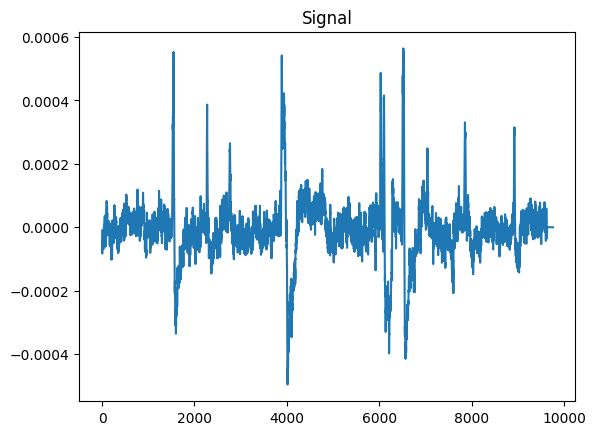

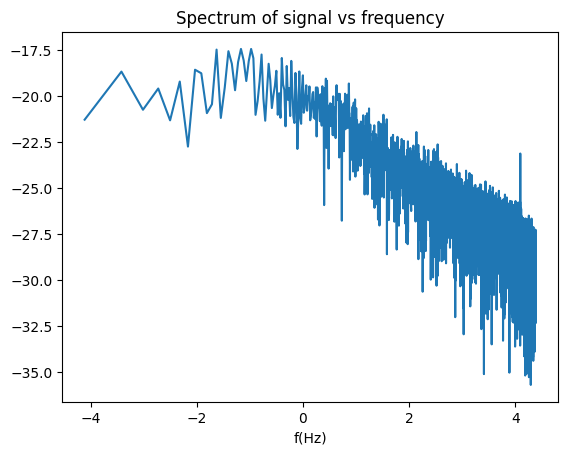

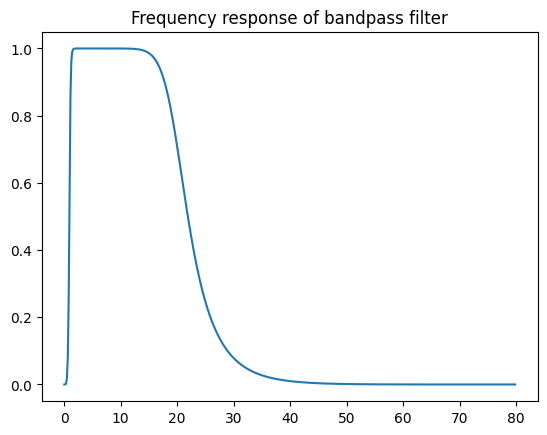

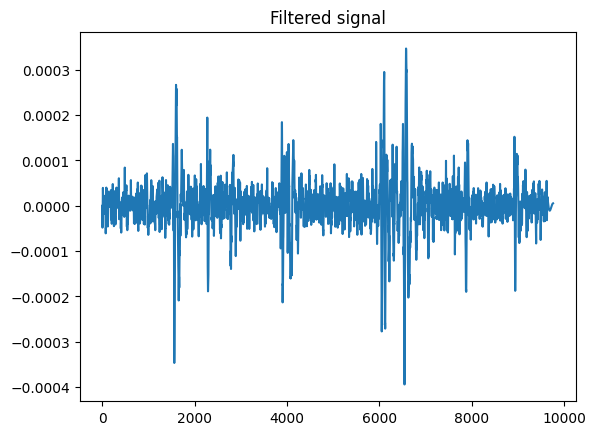

In [15]:
s=eeg_t1[0][1]

plt.figure()
plt.plot(s)
plt.title("Signal")

f,ps=sp.signal.periodogram(s,fs)
plt.figure()
plt.plot(np.log(f),np.log(ps))
plt.title("Spectrum of signal vs frequency")
plt.xlabel("f(Hz)")

b,a=sp.signal.butter(5,[1,20],fs=fs,btype="band")
s_f=sp.signal.lfilter(b,a,x=s)
w,h=sp.signal.freqz(b,a,fs=fs)

plt.figure()
plt.plot(w,np.abs(h))
plt.title("Frequency response of bandpass filter")

plt.figure()
plt.plot(s_f)
plt.title("Filtered signal")

In [16]:
#averaging over all of channels in a group
#low-pass filtering up to 5Hz

t1_avg={}

for i in range(len(eeg_t1)):
    
    s=0*eeg_t1[i][0]

    for j in range(len(eeg_t1[i])):
        s=s+eeg_t1[i][j]

    t1_avg[i]=sp.signal.lfilter(b,a,x=s/len(eeg_t1[i]))
    t1_avg[i]=t1_avg[i]-np.mean(t1_avg[i])
        

In [17]:
#z-score normalization

t1_navg={}

for i in range(n):
    t1_navg[i]=(t1_avg[i]-np.mean(t1_avg[i]))/np.std(t1_avg[i])

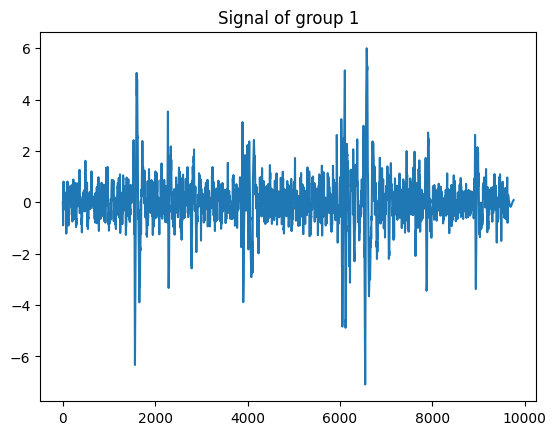

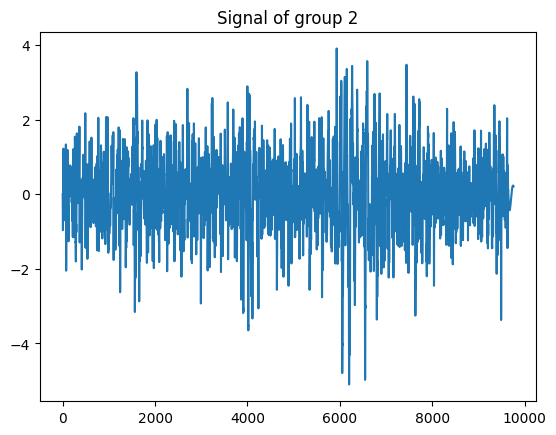

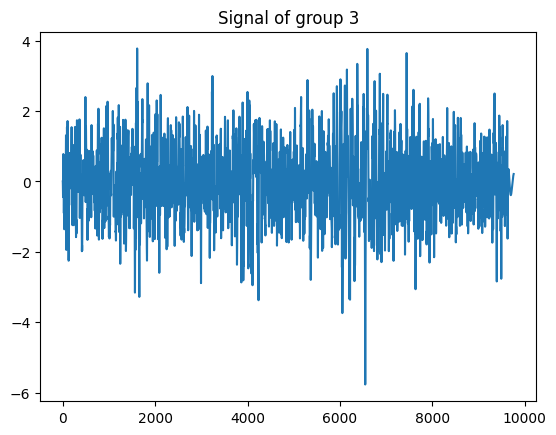

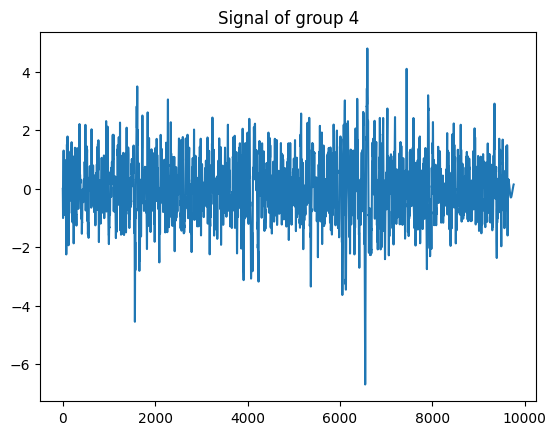

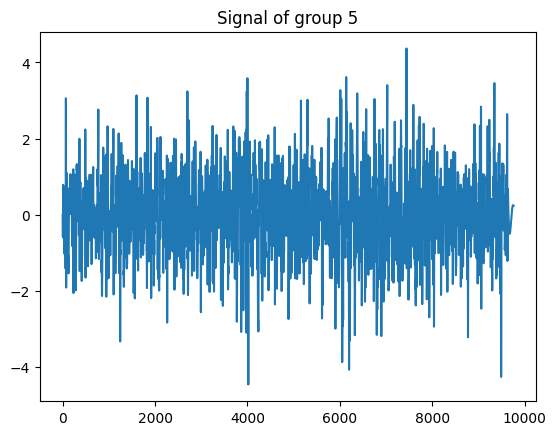

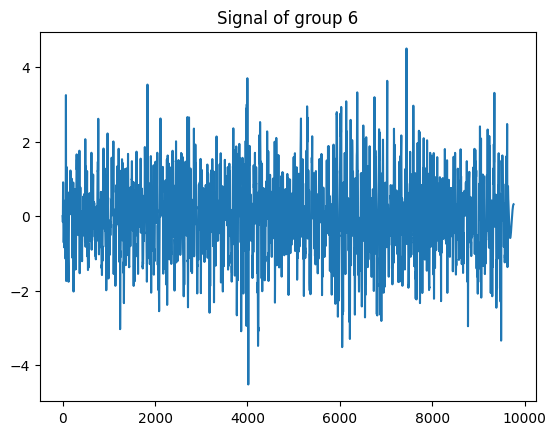

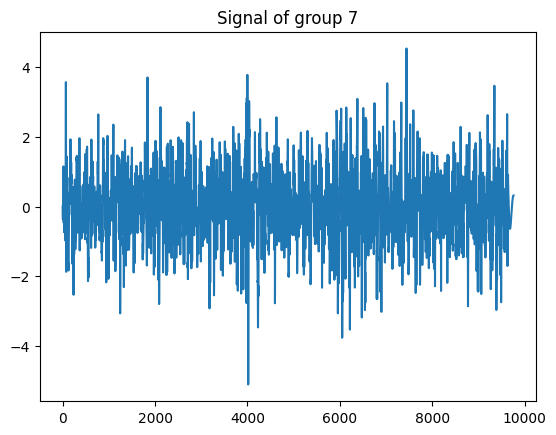

In [21]:
for i in range(n):
    plt.figure()
    plt.plot(t1_navg[i])
    plt.title("Signal of group "+str(i+1))

In [8]:
def M(data,n,dt,bins):

    x=data
    x_min=np.min(x)
    x_max=np.max(x)
    x_bins=np.linspace(x_min,x_max,bins)
    d1=np.empty(len(x_bins))
    d1_error=np.empty(len(x_bins))
    dx=x_bins[1]-x_bins[0]
    x_p=x[0:-1]

    for i in range(bins):
        
        q=np.where((x_p>x_bins[i]-dx/2) & (x_p<x_bins[i]+dx/2))[0]
        if len(q)>0:
            l=(x[q+1]-x[q])**n
            d1[i]=np.mean(l)/dt
            d1_error[i]=np.std(l)/(np.sqrt(len(q))*dt)
        else:
            d1[i]=0
            d1_error[i]=0        


    return x_bins,d1,d1_error

Text(0.5, 1.0, 'M_6(x)')

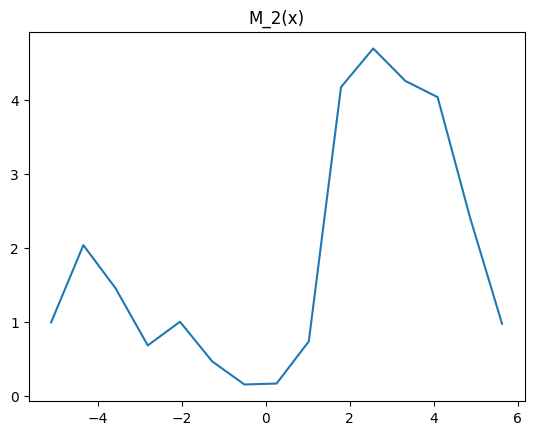

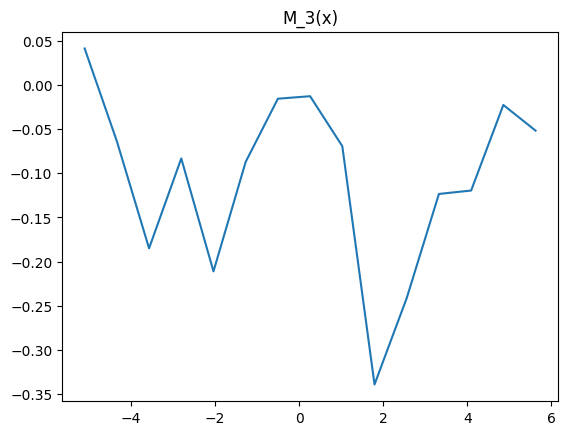

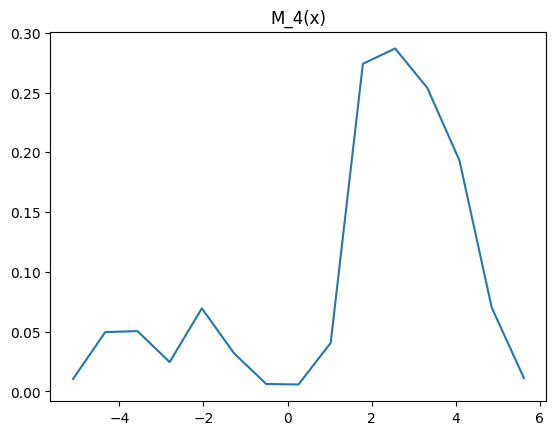

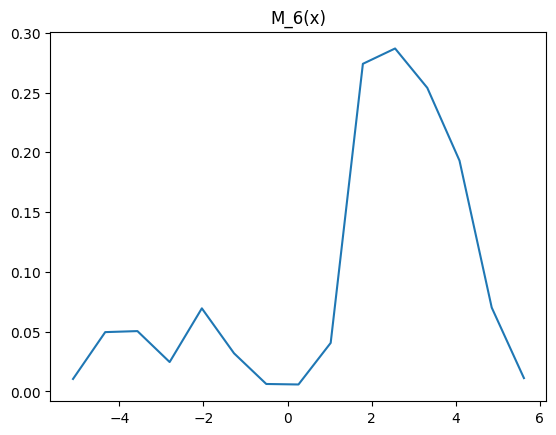

In [9]:
m2=M(t1_navg[0],2,1/fs,15)
m3=M(t1_navg[0],3,1/fs,15)
m4=M(t1_navg[0],4,1/fs,15)
m6=M(t1_navg[0],4,1/fs,15)

plt.figure()
plt.plot(m2[0],m2[1])
plt.title("M_2(x)")

plt.figure()
plt.plot(m3[0],m3[1])
plt.title("M_3(x)")

plt.figure()
plt.plot(m4[0],m4[1])
plt.title("M_4(x)")


plt.figure()
plt.plot(m6[0],m6[1])
plt.title("M_6(x)")

In [10]:
import hints

t1_array=np.empty((len(t1_navg[0]),n))
for i in range(n):
    t1_array[:,i]=t1_navg[i]

drift_model=hints.kmcc(ts_array=t1_array,dt=1/fs,interaction_order=[1,2],estimation_mode="drift")

In [11]:
coeffs=drift_model.get_coefficients()
coeff_labels=drift_model._construct_keys()

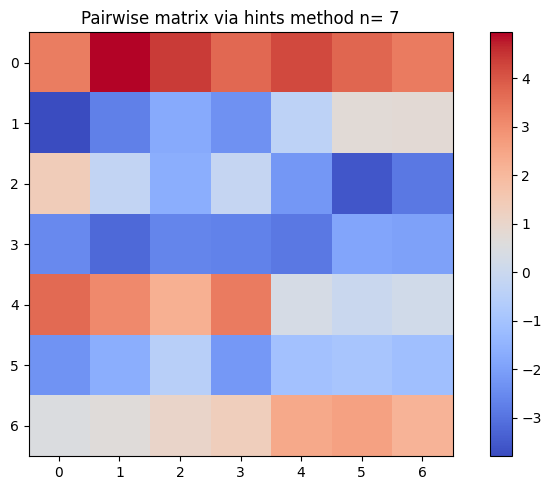

In [23]:
pair_wise_matrix=coeffs.values[0:7,:]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Pairwise matrix via hints method n= "+str(n))
im=plt.imshow(pair_wise_matrix,"coolwarm")
plt.colorbar(im)
plt.tight_layout()

#plt.subplot(1,2,2)
#plt.scatter(np.arange(7),np.real(sp.linalg.eig(pair_wise_matrix)[0]))

plt.tight_layout()

In [13]:
print(sp.linalg.eig(pair_wise_matrix)[0])

[-0.10859709+1.96395348j -0.10859709-1.96395348j -0.51007204+1.70492812j
 -0.51007204-1.70492812j -0.25828419+0.79522657j -0.25828419-0.79522657j
 -0.3692409 +0.j        ]


In [14]:
#plotting pair-wise matrix
print(coeff_labels)
print(coeffs.to_string())

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x1x1', 'x1x2', 'x1x3', 'x1x4', 'x1x5', 'x1x6', 'x1x7', 'x2x2', 'x2x3', 'x2x4', 'x2x5', 'x2x6', 'x2x7', 'x3x3', 'x3x4', 'x3x5', 'x3x6', 'x3x7', 'x4x4', 'x4x5', 'x4x6', 'x4x7', 'x5x5', 'x5x6', 'x5x7', 'x6x6', 'x6x7', 'x7x7']
              0          1          2          3          4          5          6
x1     3.332283   4.944244   4.405355   3.711980   4.220339   3.731342   3.365269
x2    -3.794442  -2.708714  -1.744648  -2.357513  -0.351544   0.730694   0.750652
x3     1.372912  -0.222261  -1.629730  -0.141963  -2.203149  -3.570052  -2.880199
x4    -2.531262  -3.191211  -2.603690  -2.677397  -2.889860  -1.862687  -1.959919
x5     3.662615   3.082414   2.235062   3.366144   0.327443  -0.015898   0.189613
x6    -2.319369  -1.621374  -0.504904  -2.175164  -1.044394  -0.897327  -1.103596
x7     0.506068   0.659058   1.050746   1.309495   2.404515   2.568312   2.130295
x1x1  -3.288354  -1.582734  -1.985997  -3.503306   1.021983   1.277653   0.63

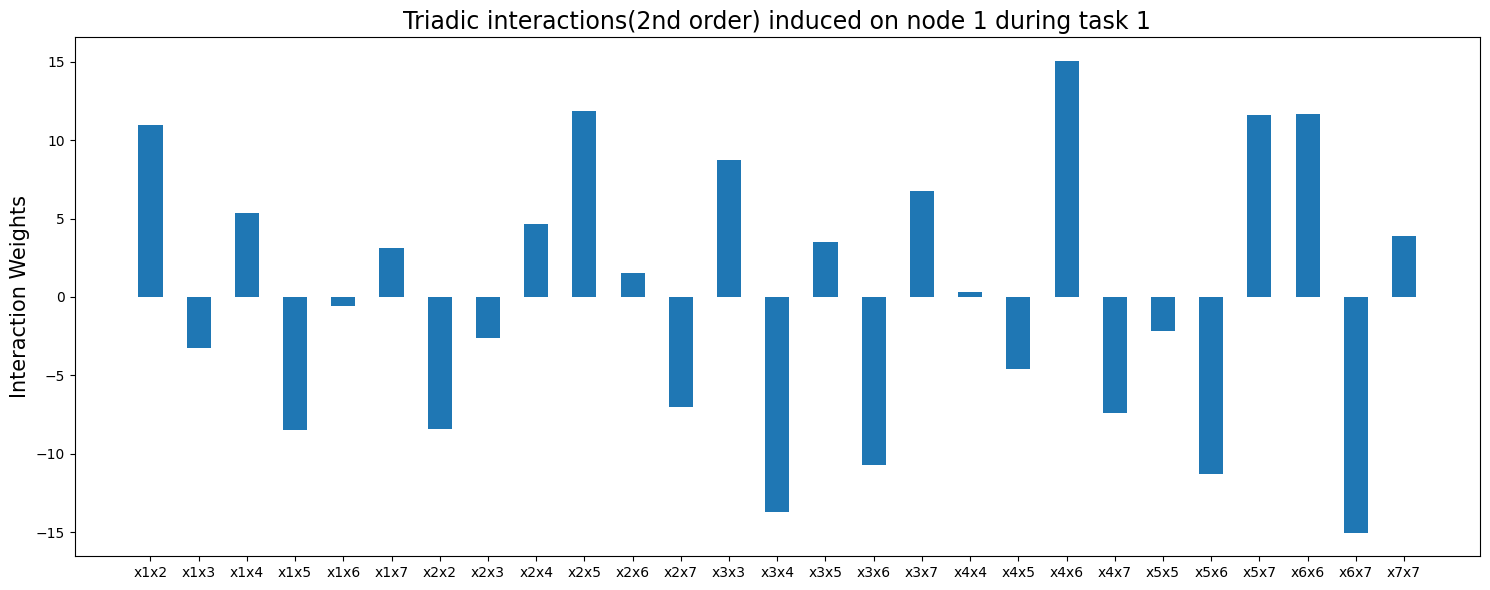

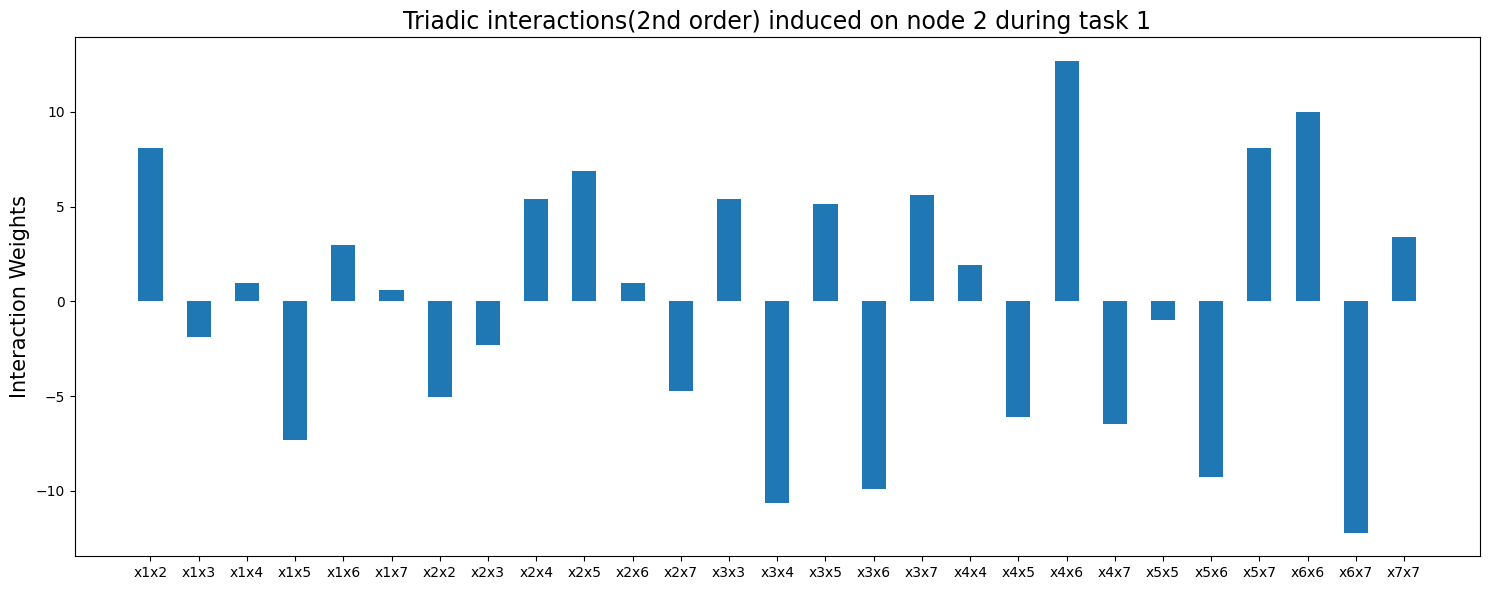

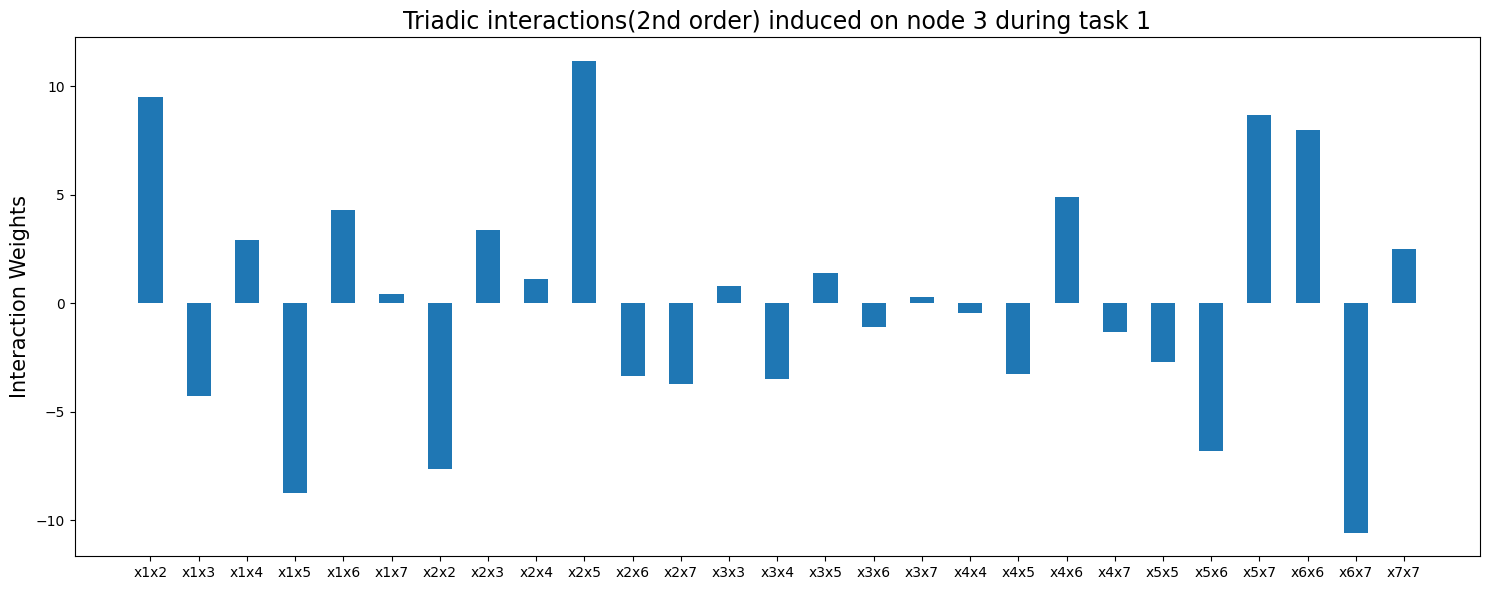

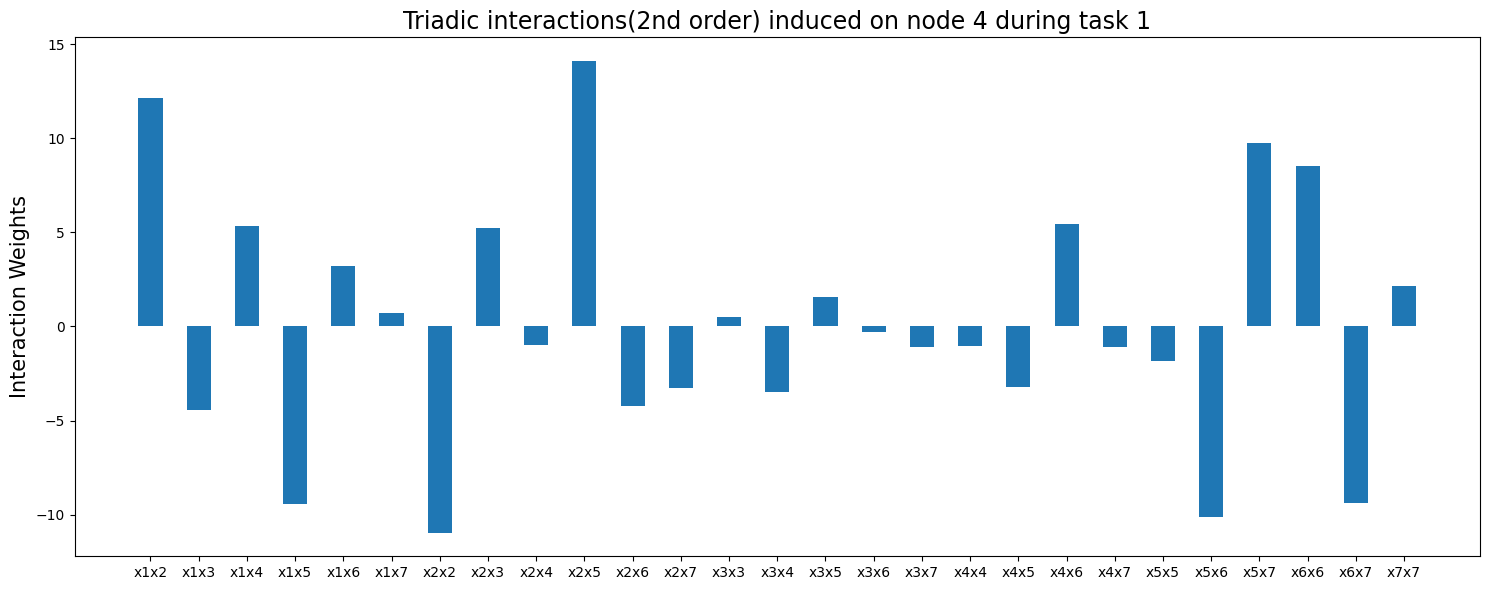

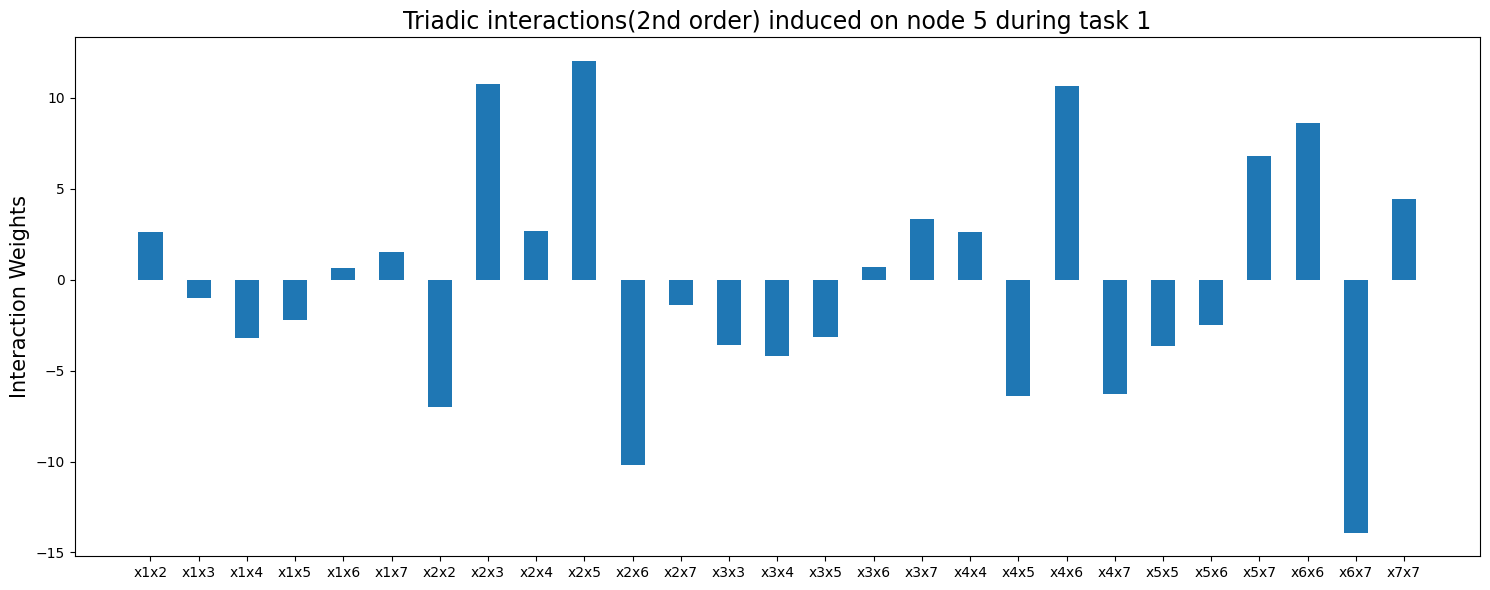

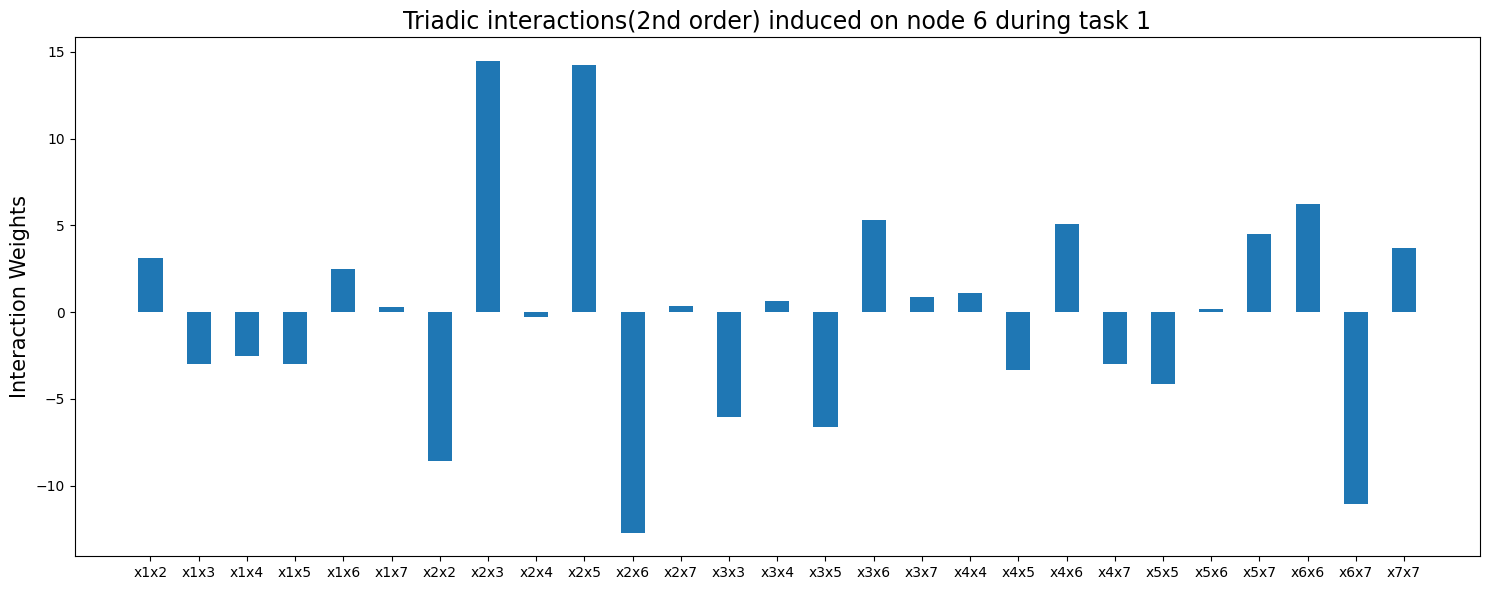

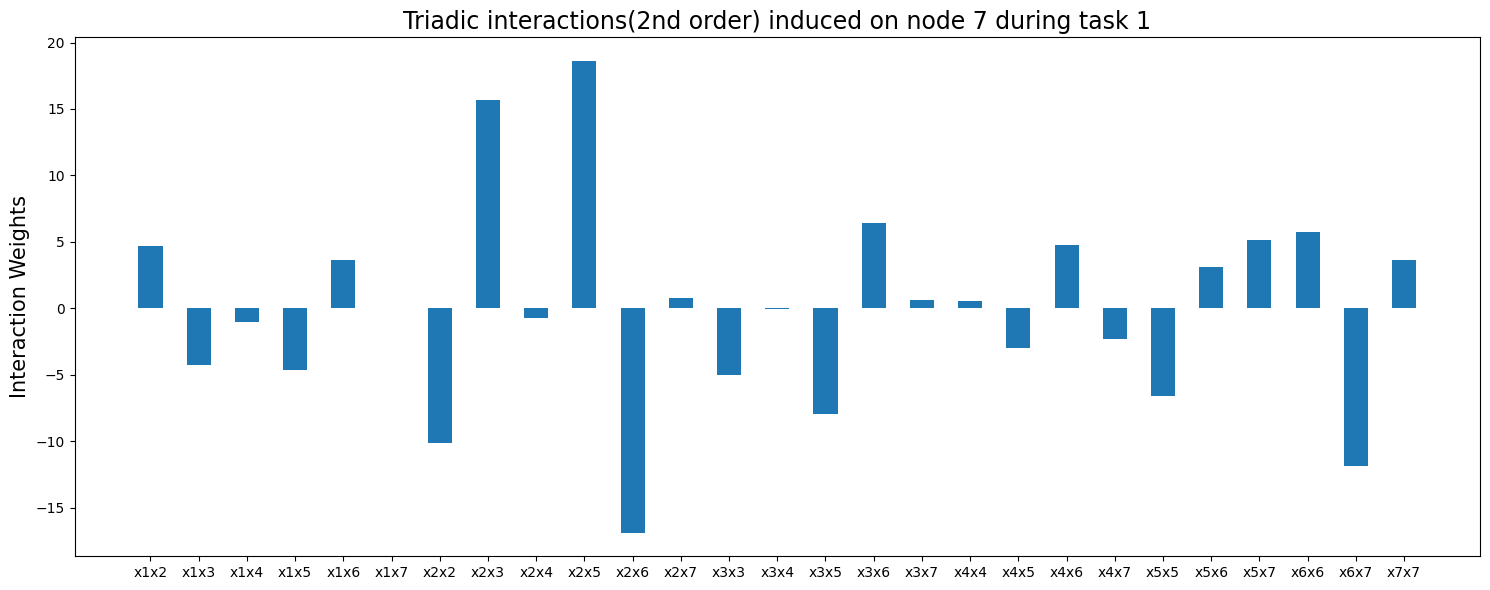

In [15]:
# making bar plots of higher-order interactions

for i in range(n):

    plt.figure(figsize=(15,6))
    plt.title("Triadic interactions(2nd order) induced on node "+str(i+1)+" during task 1",fontsize=17)
    plt.bar(coeff_labels[8:],coeffs.values[8:,i].flatten(),width=0.5)
    plt.ylabel("Interaction Weights",fontsize=15)
    plt.tight_layout()
